# IBM Consumer Complaint Classification Modeling
### Import Modules

In [3]:
import pandas as pd
import numpy as np

### Load Stemmed Narratives

In [5]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)
df=pd.read_csv('gdrive/My Drive/IBM/stemmed.csv')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [6]:
df.head()

,Sub-product,Consumer complaint narrative,stemmed narrative
0,General-purpose credit card or charge card,CITI BANK in his response to XXXX asked me idi...,citi bank respons ask idiot question inapplic...
1,Other debt,THIS ACCOUNT IS A RESULT OF IDENTITY THEFT.,account result ident theft
2,Other debt,Pro Collect has sent documents that dont match...,pro collect sent document dont match move date...
3,Medical debt,On XX/XX/2019 I sent PlusFour Inc a certified ...,2019 sent plusfour inc certifi letter via usp ...
4,Credit card debt,Client Services is reporting negative informat...,client servic report neg inform credit report ...


In [7]:
df['stemmed narrative'] = df['stemmed narrative'].astype(str)

### Label Categories

In [8]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['labels'] = le.fit_transform(df['Sub-product'])
df.head()

,Sub-product,Consumer complaint narrative,stemmed narrative,labels
0,General-purpose credit card or charge card,CITI BANK in his response to XXXX asked me idi...,citi bank respons ask idiot question inapplic...,14
1,Other debt,THIS ACCOUNT IS A RESULT OF IDENTITY THEFT.,account result ident theft,28
2,Other debt,Pro Collect has sent documents that dont match...,pro collect sent document dont match move date...,28
3,Medical debt,On XX/XX/2019 I sent PlusFour Inc a certified ...,2019 sent plusfour inc certifi letter via usp ...,23
4,Credit card debt,Client Services is reporting negative informat...,client servic report neg inform credit report ...,5


### Load FastText Pre-trained Word Embeddings

In [9]:
def load_embeddings(filename):
    embeddings = {}
    with open(filename) as f:
        for line in f:
            values = line.rstrip().split(' ')
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings
embeddings = load_embeddings('gdrive/My Drive/IBM/crawl-300d-2M.vec')

def filter_embeddings(embeddings, word_index, vocab_size, dim=300):
    embedding_matrix = np.full([vocab_size, dim],0)
    for word, i in word_index.items():
        if i >= vocab_size:
            continue
        vector = embeddings.get(word)
        if vector is not None:
            embedding_matrix[i] = vector
    return embedding_matrix

Tokenize.

In [10]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(list(df['stemmed narrative']))

Using TensorFlow backend.


In [11]:
num_words = len(tokenizer.word_index)
num_words

108913

Train test split.

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['stemmed narrative'], df['labels'], stratify = df['labels'], test_size = 0.1, random_state = 0)

In [13]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [14]:
embedding_size = 300
vocab_size = len(tokenizer.word_index) + 1 # 1 for padding
embedding_matrix = filter_embeddings(embeddings, tokenizer.word_index, vocab_size, embedding_size)
oov = len(set(tokenizer.word_index) - set(embeddings))
print('OOV: {}'.format(oov))

OOV: 78222


In [15]:
# percentage out of vocabulary
oov/num_words

0.7182062747330438

### Pad Sequences

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


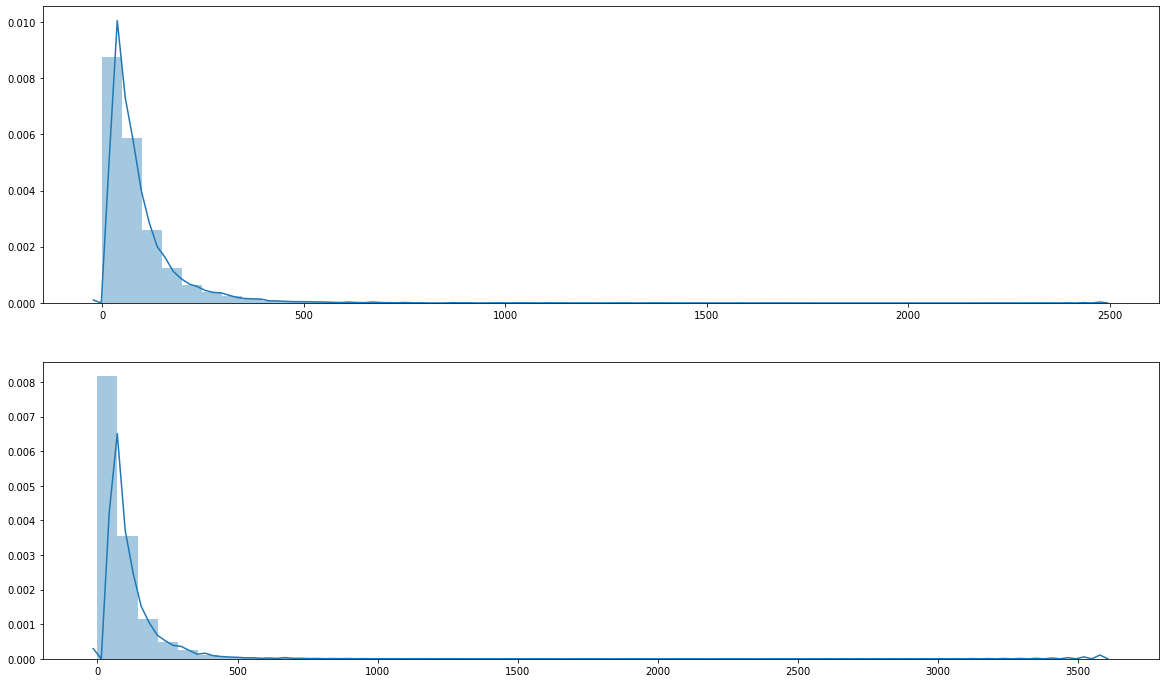

In [16]:
import matplotlib.pylab as plt
import seaborn as sns
fig, axes = plt.subplots(2,1,figsize = (20,12))
sns.distplot(pd.Series(X_test).apply(lambda x: len(x)), ax = axes[0])
sns.distplot(pd.Series(X_train).apply(lambda x: len(x)), ax = axes[1]);

In [17]:
from keras.preprocessing.sequence import pad_sequences
maxlen = 500
X_train = pad_sequences(X_train,maxlen = maxlen)
X_test = pad_sequences(X_test,maxlen = maxlen)

### Build and Fit LSTM Model on Stemmed Narratives

In [17]:
from keras import Sequential
from keras.layers import Embedding, Flatten, Dense, Dropout, LSTM, Bidirectional
from keras.callbacks import ModelCheckpoint
model_ckpnt = ModelCheckpoint("best.h5",verbose = 1, save_best_only = True)
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, 300, input_length = maxlen))
model.add(Bidirectional(LSTM(50, return_sequences = True)))
model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(47, activation = 'softmax'))
model.summary()
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])
model.fit(X_train, y_train, epochs = 3, batch_size = 1024, validation_split=0.02, callbacks=[model_ckpnt]) # add callbacks

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 300)          32674200  
_________________________________________________________________
bidirectional_3 (Bidirection (None, 500, 100)          140400    
_________________________________________________________________
flatten_3 (Flatten)          (None, 50000)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                3200064   
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 47)                3055      
Total params: 36,017,719
Trainable params: 36,017,719
Non-trainable params: 0
__________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 297726 samples, validate on 6077 samples
Epoch 1/3
297726/297726 [==============================] - 5480s 18ms/step - loss: 1.4481 - acc: 0.6223 - val_loss: 0.9909 - val_acc: 0.7086

Epoch 00001: val_loss improved from inf to 0.99093, saving model to best.h5
Epoch 2/3
297726/297726 [==============================] - 5512s 19ms/step - loss: 0.9432 - acc: 0.7246 - val_loss: 0.8764 - val_acc: 0.7384

Epoch 00002: val_loss improved from 0.99093 to 0.87640, saving model to best.h5
Epoch 3/3
297726/297726 [==============================] - 5330s 18ms/step - loss: 0.8115 - acc: 0.7570 - val_loss: 0.8646 - val_acc: 0.7456

Epoch 00003: val_loss improved from 0.87640 to 0.86458, saving model to best.h5


### Evaluate

In [18]:
model.load_weights('best.h5')
preds = model.predict(X_test, batch_size = 1024, verbose = 1)

33756/33756 [==============================] - 162s 5ms/step


In [19]:
preds = preds.argmax(1)

In [20]:
# Accuracy
sum(preds == y_test)/len(y_test)

0.7377355136864557

In [22]:
#Weighted F1
from sklearn.metrics import f1_score
f1_weighted = f1_score(y_test, preds, average='weighted')
f1_weighted

0.7168703132756683

In [23]:
# Micro F1
from sklearn.metrics import f1_score
f1_micro = f1_score(y_test, preds, average='micro')
f1_micro

0.7377355136864557

In [25]:
stemmed_eval = pd.DataFrame.from_dict({'accuracy':accuracy, 'f1 weighted':f1_weighted, 'f1 micro':f1_micro}, orient='index',columns=['scores'])
stemmed_eval

,scores
accuracy,0.737736
f1 weighted,0.716870
f1 micro,0.737736


### Load Lemmatized Narratives and Process

In [18]:
df2=pd.read_csv('gdrive/My Drive/IBM/lemmatized.csv')
df2['stemmed narrative'] = df2['stemmed narrative'].astype(str)

Label categories.

In [19]:
le = LabelEncoder()
df2['labels'] = le.fit_transform(df2['Sub-product'])
df2.head()

,Sub-product,Consumer complaint narrative,stemmed narrative,labels
0,General-purpose credit card or charge card,CITI BANK in his response to XXXX asked me idi...,citi bank response asked idiotic question ina...,14
1,Other debt,THIS ACCOUNT IS A RESULT OF IDENTITY THEFT.,account result identity theft,28
2,Other debt,Pro Collect has sent documents that dont match...,pro collect sent document dont match move date...,28
3,Medical debt,On XX/XX/2019 I sent PlusFour Inc a certified ...,2019 sent plusfour inc certified letter via us...,23
4,Credit card debt,Client Services is reporting negative informat...,client service reporting negative information ...,5


Tokenize.

In [20]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(list(df2['stemmed narrative']))

In [21]:
num_words = len(tokenizer.word_index)
num_words

132563

Train test split and load fastText embeddings.

In [22]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(df2['stemmed narrative'], df2['labels'], stratify = df2['labels'], test_size = 0.1, random_state = 0)
X_train_2 = tokenizer.texts_to_sequences(X_train_2)
X_test_2 = tokenizer.texts_to_sequences(X_test_2)

In [23]:
embedding_size = 300
vocab_size = len(tokenizer.word_index) + 1 # 1 for padding
embedding_matrix = filter_embeddings(embeddings, tokenizer.word_index, vocab_size, embedding_size)
oov = len(set(tokenizer.word_index) - set(embeddings))
print('OOV: {}'.format(oov))

OOV: 76126


In [24]:
# percentage out of vocabulary
oov/num_words

0.5742628033463334

In [25]:
X_train_2 = pad_sequences(X_train_2,maxlen = maxlen)
X_test_2 = pad_sequences(X_test_2,maxlen = maxlen)

### Build and Fit LSTM Model on Lemmatized Narratives

In [26]:
from keras import Sequential
from keras.layers import Embedding, Flatten, Dense, Dropout, LSTM, Bidirectional
from keras.callbacks import ModelCheckpoint
model_ckpnt = ModelCheckpoint("best2.h5",verbose = 1, save_best_only = True)
model_2 = Sequential()
model_2.add(Embedding(len(tokenizer.word_index) + 1, 300, input_length = maxlen))
model_2.add(Bidirectional(LSTM(50, return_sequences = True)))
model_2.add(Flatten())
model_2.add(Dense(64, activation = 'relu'))
model_2.add(Dropout(0.2))
model_2.add(Dense(47, activation = 'softmax'))
model_2.summary()
model_2.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])
model_2.fit(X_train_2, y_train_2, epochs = 3, batch_size = 1024, validation_split=0.02, callbacks=[model_ckpnt]) # add callbacks

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 300)          39769200  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 500, 100)          140400    
_________________________________________________________________
flatten_1 (Flatten)          (None, 50000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                3200064   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 47)                3055      
Total params: 43,112,719
Trainable params: 43,112,719
Non-trainable params: 0
__________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 297726 samples, validate on 6077 samples
Epoch 1/3
297726/297726 [==============================] - 5102s 17ms/step - loss: 1.4572 - acc: 0.6235 - val_loss: 0.9728 - val_acc: 0.7120

Epoch 00001: val_loss improved from inf to 0.97283, saving model to best2.h5
Epoch 2/3
297726/297726 [==============================] - 5099s 17ms/step - loss: 0.9211 - acc: 0.7296 - val_loss: 0.8933 - val_acc: 0.7369

Epoch 00002: val_loss improved from 0.97283 to 0.89331, saving model to best2.h5
Epoch 3/3
297726/297726 [==============================] - 5190s 17ms/step - loss: 0.7751 - acc: 0.7673 - val_loss: 0.8623 - val_acc: 0.7446

Epoch 00003: val_loss improved from 0.89331 to 0.86228, saving model to best2.h5


### Evaluate

In [27]:
model_2.load_weights('best2.h5')
preds2 = model_2.predict(X_test_2, batch_size = 1024, verbose = 1)

33756/33756 [==============================] - 153s 5ms/step


In [28]:
preds2= preds2.argmax(1)

In [30]:
# Accuracy
sum(preds2 == y_test_2)/len(y_test_2)

0.7446676146462851

In [31]:
# Weighted F1
f1_weighted_2 = f1_score(y_test_2, preds2, average='weighted')
f1_weighted_2

0.7208350069344864

In [32]:
# Micro F1
f1_micro_2 = f1_score(y_test_2, preds2, average='micro')
f1_micro_2

0.7446676146462851

In [34]:
lemmatized_eval = pd.DataFrame.from_dict({'accuracy':accuracy2, 'f1 weighted':f1_weighted_2, 'f1 micro':f1_micro_2}, orient='index',columns=['scores'])
lemmatized_eval

,scores
accuracy,0.744668
f1 weighted,0.720835
f1 micro,0.744668
